In [1]:
#load predictions
import os
import h5py
import numpy as np
from meld_classifier.meld_cohort import MeldCohort, MeldSubject


Setting MELD_DATA_PATH to /rds/user/kw350/rds-kw350-meld/meld_data/Data/
Setting BASE_PATH to /rds/user/kw350/rds-kw350-meld/meld_data/Data/
Setting EXPERIMENT_PATH to /rds/user/kw350/rds-kw350-meld/experiments/kw350/
No fs_subjects_path defined in /home/kw350/software/gdl/meld_classifier/meld_config.ini!


In [2]:
predictions_file_1 = os.path.join('/rds/project/kw350',
             'rds-kw350-meld/experiments',
             'co-ripa1/iteration_21-09-15/ensemble_21-09-15',
             'fold_all/results/',
             'predictions_ensemble_iteration.hdf5')

predictions_file_2 = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-17/ensemble_21-09-20/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')

In [6]:
predictions_file = os.path.join('/rds/project/kw350/rds-kw350-meld',
                                'experiments_graph/co-ripa1',
                                '22-09-30_real_eval_datasetv6/results/predictions.hdf5')

In [5]:
def load_prediction(subject,hdf5):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi]['prediction'][:]
    return results

In [9]:
with h5py.File(predictions_file, "r") as f:
    subjects = list(f.keys())

In [10]:
# with h5py.File(predictions_file_1, "r") as f:
#     subjects1 = list(f.keys())
# with h5py.File(predictions_file_2, "r") as f:
#     subjects2 = list(f.keys())    
    
# subjects = np.unique(subjects1+subjects2)
# subjects[0]

In [11]:
c = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')


In [18]:
def tp_fp_fn_tn(label,predictions):
    tp = np.logical_and(label,predictions).sum()
    fp = np.logical_and(predictions, ~label).sum()
    fn = np.logical_and(~predictions, label).sum()
    tn = np.logical_and(~predictions, ~label).sum()
    return tp, fp, fn, tn

In [152]:
stored_scores = [[],[],[],[],[],[]]
features=[]
threshes = [0.2,0.3,0.35,0.4,0.45]
for si,subject in enumerate(subjects):
    if si%100==0:
        print(si/len(subjects))
        
    results=[]
    try:
        hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-15/ensemble_21-09-15/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')
        result_hemis = load_prediction(subject,hdf_predictions)
        results.append(result_hemis)
    except KeyError:
        hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-17/ensemble_21-09-20/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')
        result_hemis = load_prediction(subject,hdf_predictions)
        results.append(result_hemis)
        
    new_result_hemis = load_prediction(subject,predictions_file)
    for t in threshes:
        ti={}
        for hemi in ['lh','rh']:
            ti[hemi]=new_result_hemis[hemi]>t
        
        results.append(ti)
    labels_hemis = {}
    
    subj = MeldSubject(subject,cohort=c)
    detected = False
    stats_stored = np.zeros((len(results),4))
    
    for hemi in ['lh','rh']:
        _, label = subj.load_feature_lesion_data(
            features, hemi=hemi, features_to_ignore=[]
        )
        for ri,r in enumerate(results):
            scores = tp_fp_fn_tn(label[c.cortex_mask],r[hemi])
            stats_stored[ri] +=scores
            
    
        
        
#     dice_lesion = np.nan_to_num((2*tp)/(2*tp+fn+fp))
#     dice_nonlesion = (2*tn)/(2*tn+fn+fp)
    for ri,r in enumerate(results):
        stored_scores[ri].append([subject,subj.is_patient])
        stored_scores[ri][-1].extend(list(stats_stored[ri]))
    

0.0


In [186]:
def dices(scores):
    dices_lesion = np.nan_to_num((2*scores[0])/(2*scores[0]+scores[1]+scores[2]))
    dices_nonlesion = np.nan_to_num((2*scores[3])/(2*scores[3]+scores[1]+scores[2]))
    return dices_lesion,dices_nonlesion

def add_dice_spec_and_sens(df):
    df['Dice_lesion'],df['Dice_nonlesion'], = dices(df[['TP','FP','FN','TN']].values.T)
    df['Detected'] = df['TP']>0
    sensitivity = np.mean(df['Detected'][df['Group']])
    fps = df['FP']>0
    specificity = np.mean(fps[~df['Group']]==0)
    mean_dice = np.mean(df['Dice_lesion'][df['Group']])
    mean_dice_non = np.mean(df['Dice_nonlesion'])
    return df, sensitivity, specificity,mean_dice, mean_dice_non

In [187]:
import pandas as pd
import scipy.stats as st

In [188]:
stored_dices = []
stored_nondice = []
sensitivities = []
specificities = []
for s in stored_scores:
    df_old = pd.DataFrame(s,columns=['Subject ID','Group',
                                          'TP','FP','FN','TN',])
    df_old,sensitivity,specificity,mean_dice,mean_non_dice = add_dice_spec_and_sens(df_old)
    stored_dices.append(mean_dice)
    stored_nondice.append(mean_non_dice)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

/tmp/ipykernel_250670/3877210344.py:2: RuntimeWarning: invalid value encountered in true_divide
  dices_lesion = np.nan_to_num((2*scores[0])/(2*scores[0]+scores[1]+scores[2]))
/tmp/ipykernel_250670/3877210344.py:2: RuntimeWarning: invalid value encountered in true_divide
  dices_lesion = np.nan_to_num((2*scores[0])/(2*scores[0]+scores[1]+scores[2]))


In [189]:
specificities

[0.5384615384615384, 0.0, 0.0, 0.0, 0.0, 0.5384615384615384]

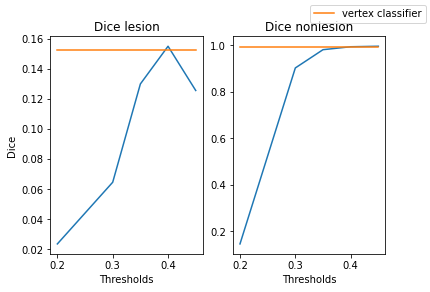

In [190]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2)
ax[0].plot(threshes,stored_dices[1:],)
ax[0].plot([threshes[0],threshes[-1]],[stored_dices[0],stored_dices[0]],label='vertex classifier')
ax[0].set_xlabel('Thresholds')
ax[0].set_ylabel('Dice')

ax[0].set_title("Dice lesion")
#,stored_nondice
ax[1].plot(threshes,stored_nondice[1:],)
ax[1].plot([threshes[0],threshes[-1]],[stored_nondice[0],stored_nondice[0]])
#,stored_nondice
ax[1].set_xlabel('Thresholds')
ax[1].set_title("Dice nonlesion")
fig.legend()

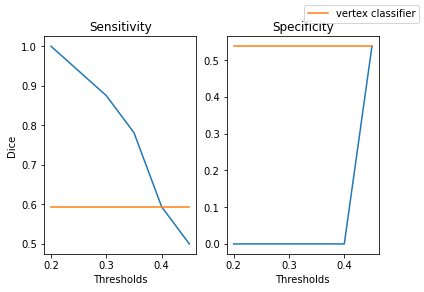

In [194]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2)
ax[0].plot(threshes,sensitivities[1:],)
ax[0].plot([threshes[0],threshes[-1]],[sensitivities[0],sensitivities[0]],label='vertex classifier')
ax[0].set_xlabel('Thresholds')
ax[0].set_ylabel('Dice')

ax[0].set_title("Sensitivity")
#,stored_nondice
ax[1].plot(threshes,specificities[1:],)
ax[1].plot([threshes[0],threshes[-1]],[specificities[0],specificities[0]])
#,stored_nondice
ax[1].set_xlabel('Thresholds')
ax[1].set_title("Specificity")
fig.legend()

In [195]:
sensitivities

[0.59375, 1.0, 0.875, 0.78125, 0.59375, 0.5]

In [196]:
specificities

[0.5384615384615384, 0.0, 0.0, 0.0, 0.0, 0.5384615384615384]